Notebook by Eric Klopfer, using data from the PDC workshop on 2/4/17.

In [273]:
#load relevant libraries
import pandas as pd
from pandas import DataFrame 
from pandas import Series
import json,csv
#import delorean
import matplotlib.pyplot as plt
#this allows your graphs to show up in the nb, super important
%matplotlib inline 
import datetime
from datetime import datetime
import matplotlib.dates as mdates
from collections import defaultdict 
import numpy as np
import math

#import this to make network graphs
import networkx as nx
#helps you make prettier graphs
import seaborn as sns 

In [274]:
#open data file
infilename = "events-feb-4-two-plays.json"
infile = open(infilename,'rb')
#read each line of json 
mydata = []
for line in infile:
    mydata.append(json.loads(line))

#make a dataframe from the data
myData = DataFrame(mydata)

In [275]:
#filter out trades requested and responded to in order to get list of names of traders

traders = myData[((myData.key=='TradeRequestResponded') | (myData.key=='TradeRequestSent')) &(myData.gameCode==myGame)]
traders

names = list(traders.requesterName.unique())
rnames = list(traders.recipientName.unique())
#print names
#print rnames
allnames = list(set(names + rnames))
print allnames


[u'scoto', u'elituckerraymond', u'chaimajemmali', u'chen', u'nithesh', u'chase', u'asuth', u'suzzo', u'stefanslater', u'cschimpf', u'frieda-reichsman', u'magy', u'nathanholbert', u'marleenvilleroy', u'ericklopfer', u'bertsnow', u's.bunian', u'casperharteveld', u'chris_dede', u'meredith', u'shashank', u'paulmedwal', u'kevinm', u'kitmartin', u'eliza']


In [276]:
#some functions - DIDN'T touch these - leftover from other analysis
#function to convert list of epoch times in milliseconds to a list of python datetimes
def convertTime(timeList):
    for i in range(len(timeList)):
        tempTime= datetime.fromtimestamp(timeList[i]/1000)
        timeList[i]=tempTime 
    return timeList;

#function to grab timestamp for when a year started
#this function does not handle the first year of the game; need to add to it!
def getYearStart(myYear, myData, myGame):
    dfGame = myData.loc[myData.gameCode==myGame]
    dfYears = dfGame.loc[myData.key=='GameYearIncrease']
    dfMyYear = dfYears.loc[dfYears.newYearValue==myYear]
    if len(dfMyYear)==0:
        return -1 #returns -1 if year is not in the game
    else:
        return dfMyYear.iloc[0]['timestamp']

In [277]:
#given a name and game give back an array with records for each trade requested and received
#keep a running total of both received and requested trades for the successful traders
#keep a running net score of received vs requested - e.g 10 requested and 10 received would be 0 but 10 requested and 5 received would be +5
#figure out the net value from each player's perspective on the trade, a function of the prices and ratio of the trade made
def runningTrades(name, myData, myGame):
    dfii = myData.loc[((myData['requesterName']==name) | (myData['recipientName']==name)) & (myData['gameCode']==myGame) & (myData['key']=='TradeRequestResponded') & (myData['response']==1)]
    dfi = dfii.sort_values(['timestamp'])
    
    names = list() #just the name used later
    requests = list() #cumulative number of trades requestd
    receives = list() #cumulative number of trades received
    difference = list() #cumulative value of requests - receives
    time = list() 
    ratio = list() #the price ratio including price and numbers traded - computed for each player
    #print dfii
    curTime = df.iloc[0]['timestamp']
    requests.append(0)
    receives.append(0)
    difference.append(0)
    ratio.append(0)
    names.append(name)
    time.append(curTime)
    
    for i in range(1,len(dfi)):
        curTime = dfi.iloc[i]['timestamp']
        time.append(curTime)
        #if i ==1:
            #print dfi.iloc[i]['recvResRecipient']['price'] #outgoing by recipient - high good
            #print dfi.iloc[i]['recvResRequester']['price'] #outgoing by requester - low good
            #print dfi.iloc[i]['reqResRecipient']['price']  #incoming by recipient - low good
            #print dfi.iloc[i]['reqResRequester']['price']  #incoming by requester - high good
            #print dfi.iloc[i]['reqAmt']  #requested amount
            #print dfi.iloc[i]['recvAmt']  #received amount
        recipRatio = (dfi.iloc[i]['recvResRecipient']['price'] / dfi.iloc[i]['reqResRecipient']['price'] ) * (dfi.iloc[i]['reqAmt'] / dfi.iloc[i]['recvAmt'])
        reqRatio = (dfi.iloc[i]['reqResRequester']['price']  / dfi.iloc[i]['recvResRequester']['price'] ) * (dfi.iloc[i]['recvAmt'] / dfi.iloc[i]['reqAmt'])
        #    print reqRatio 
        if dfi.iloc[i]['requesterName'] == name:
            requests.append(requests[-1]+1)
            receives.append(receives[-1])
            difference.append(requests[-1]-receives[-1])
            names.append(name)
            ratio.append(reqRatio)
        else:
            requests.append(requests[-1])
            receives.append(receives[-1]+1)
            difference.append(requests[-1]-receives[-1])
            names.append(name)
            ratio.append(recipRatio)
                    
    newDF = pd.DataFrame(
    {'name':names,
     'cumulRequests': requests,
     'cumulReceives': receives,
     'runningDifference': difference,
     'tradeRatios': ratio,
     'timestamp': time,
     'datetime': convertTime(time),
    })

    #reorder data by timestamp
    return newDF     
    

#test = traders.loc[traders['requesterName'] == "ericklopfer"]
#test

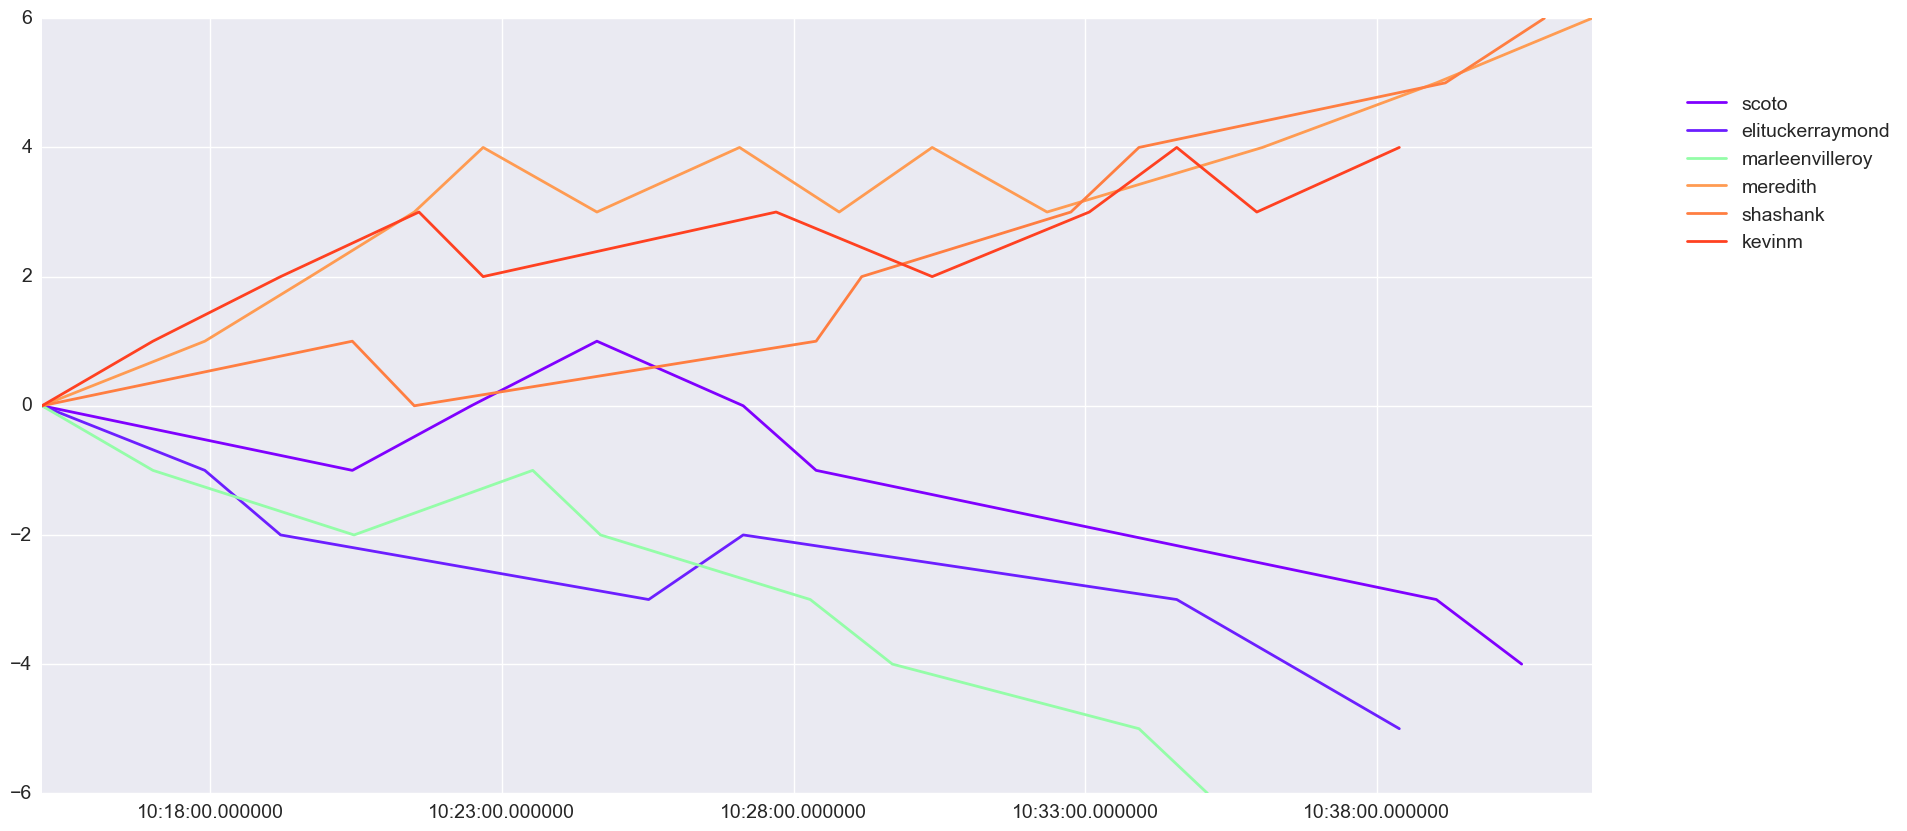

In [278]:
#this code will make a plot of people with high net positive or negative requested vs reqceived trades and show the cumulative number over time 
myGame = '2416'
fig, ax = plt.subplots(figsize=(20, 10))

#groups

#cashoutDF

#groups = [6.0]
from matplotlib import cm

finaldif = list()

color=iter(cm.rainbow(np.linspace(0,1,len(allnames))))

for name in allnames:
    nameTrades = runningTrades(name,myData,myGame)
    #print nameTrades
    sortedNameTrades = nameTrades.sort_values(['timestamp'])
    myLabel = name 
    c=next(color)
    myColor = c  
    #plt.plot(sortedNameTrades['datetime'],sortedNameTrades['cumulRequests'],label=myLabel,color=c,linewidth=2,linestyle='dashed')
    #plt.plot(sortedNameTrades['datetime'],sortedNameTrades['cumulReceives'],label=myLabel,color=c,linewidth=2)
    finaldif.append(sortedNameTrades['runningDifference'].iloc[-1])
    ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.8))
    if abs(sortedNameTrades['runningDifference'].iloc[-1])>3:
        plt.plot(sortedNameTrades['datetime'],sortedNameTrades['runningDifference'],label=myLabel,color=c,linewidth=2)

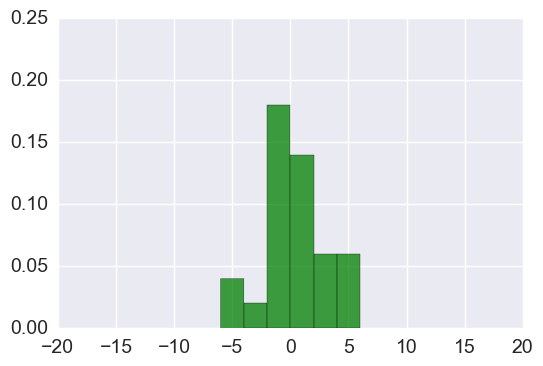

In [279]:
#histogram of distribution of net trades received vs requested
n, bins, patches = plt.hist(finaldif, 6, normed=1, facecolor='green', alpha=0.75)

plt.axis([-20, 20, 0, 0.25])
plt.grid(True)

plt.show()

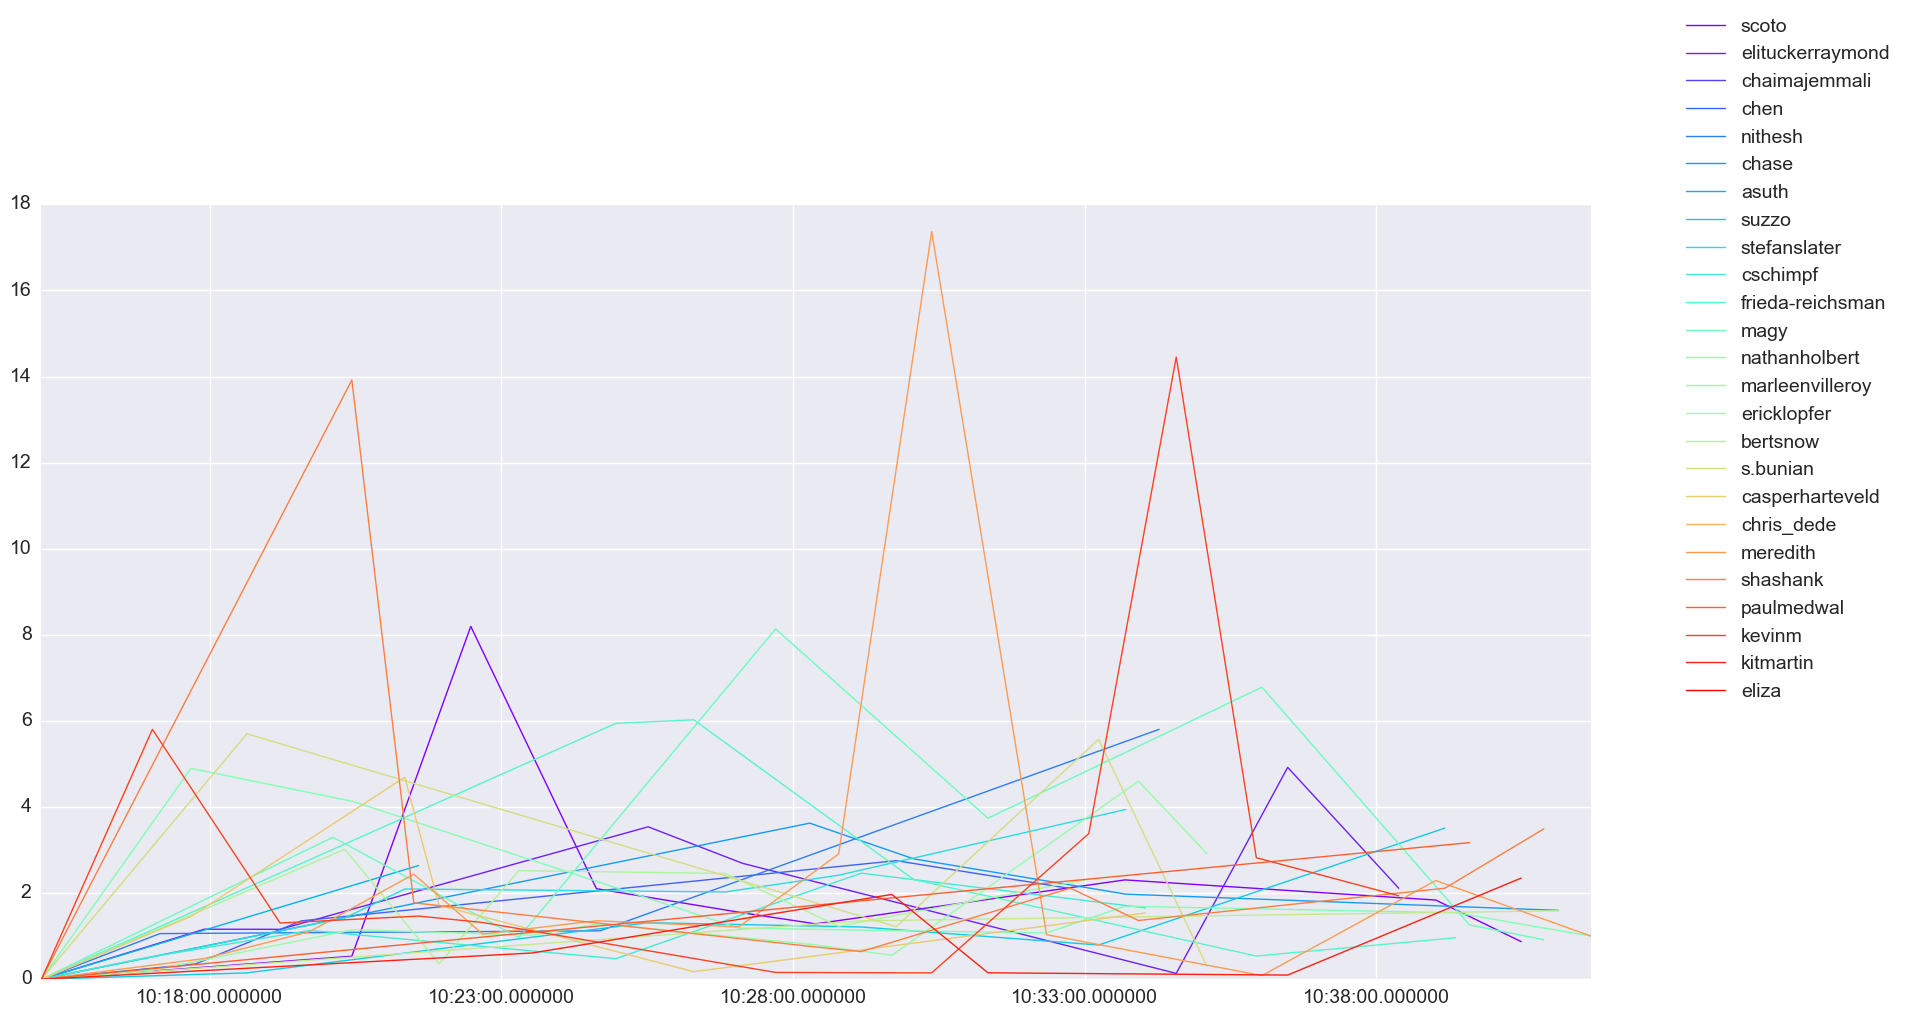

In [280]:
#plot the net value of each trade for each person.  a 1 represents a perfectly even trade from that person's perspective
#good trades should always be more than 1, bad trades less than 1
#since prices vary by player, both players can have values more than 1
myGame = '2416'
fig, ax = plt.subplots(figsize=(20, 10))

#groups

#cashoutDF

#groups = [6.0]
from matplotlib import cm

finaldif = list()

color=iter(cm.rainbow(np.linspace(0,1,len(allnames))))

for name in allnames:
    nameTrades = runningTrades(name,myData,myGame)
    #print nameTrades
    sortedNameTrades = nameTrades.sort_values(['timestamp'])
    myLabel = name 
    c=next(color)
    myColor = c  
    plt.plot(sortedNameTrades['datetime'],sortedNameTrades['tradeRatios'],label=myLabel,color=c,linewidth=1)
    #plt.plot(sortedNameTrades['datetime'],sortedNameTrades['cumulReceives'],label=myLabel,color=c,linewidth=2)
    ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.8))
    
#need to stack the incoming frames with an additional field for name.  regress ratio by time and name

In [281]:
#prepare the data for an anova by stacking frames for each player
myGame = '2416'

namesData = DataFrame()

for name in allnames:
    nameTrades = runningTrades(name,myData,myGame)
    #print nameTrades
    sortedNameTrades = nameTrades.sort_values(['timestamp'])
    namesData = namesData.append(DataFrame(sortedNameTrades))
    #print sortedNameTrades
    
namesData

,cumulReceives,cumulRequests,datetime,name,runningDifference,timestamp,tradeRatios
0,0,0,2017-02-04 10:15:06.854,scoto,0,2017-02-04 10:15:06.854,0.000000
1,1,0,2017-02-04 10:20:26.109,scoto,-1,2017-02-04 10:20:26.109,0.534367
2,1,1,2017-02-04 10:22:28.473,scoto,0,2017-02-04 10:22:28.473,8.196721
3,1,2,2017-02-04 10:24:37.737,scoto,1,2017-02-04 10:24:37.737,2.103535
4,2,2,2017-02-04 10:27:08.239,scoto,0,2017-02-04 10:27:08.239,1.543210
5,3,2,2017-02-04 10:28:23.219,scoto,-1,2017-02-04 10:28:23.219,1.287703
6,4,2,2017-02-04 10:33:41.485,scoto,-2,2017-02-04 10:33:41.485,2.307927
7,5,2,2017-02-04 10:39:01.216,scoto,-3,2017-02-04 10:39:01.216,1.840336
8,6,2,2017-02-04 10:40:29.040,scoto,-4,2017-02-04 10:40:29.040,0.874239
0,0,0,2017-02-04 10:15:06.854,elituckerraymond,0,2017-02-04 10:15:06.854,0.000000


In [317]:
#do an ANOVA of time on trade ratio.  name was added and didn't matter.
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from scipy import stats
import datetime
import time

#df.drop('time', axis=1, inplace=True)
  
namesData['time_delta'] = (namesData['datetime']-namesData['datetime'].min())  / np.timedelta64(1,'s')

formula = 'tradeRatios ~  time_delta'
model = ols(formula, namesData).fit()
aov_table = anova_lm(model, typ=2)
print model.summary()
#print aov_table
#time is a predictor of the trade ratio

                            OLS Regression Results                            
Dep. Variable:            tradeRatios   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     7.441
Date:                Sun, 05 Feb 2017   Prob (F-statistic):            0.00717
Time:                        17:51:02   Log-Likelihood:                -343.55
No. Observations:                 147   AIC:                             691.1
Df Residuals:                     145   BIC:                             697.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      1.2180      0.352      3.465      0.0

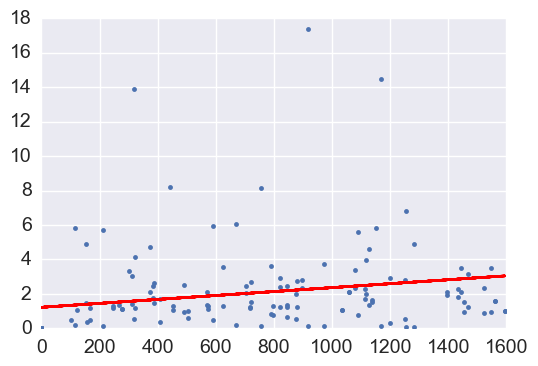

In [324]:
#draw a graph with a line of time vs trade ratios
plt.plot(namesData['time_delta'],namesData['tradeRatios'],'.')
fit = np.polyfit(namesData['time_delta'],namesData['tradeRatios'], deg=1)
plt.plot(namesData['time_delta'], fit[0] * namesData['time_delta'] + fit[1], color='red')  